In [193]:
import torch
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split
import preprocessing
import torch.optim as optim

In [194]:
def split_data(df):
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1
    
    df_use, df_discard = train_test_split(df, test_size=0.8, random_state=42)

    train_val, test = train_test_split(df_use, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)

    return train, val, test

In [195]:
class CustomDataset2(Dataset):
    def __init__(self, image_folder, dataframe, transform=None):
        self.image_folder = image_folder
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] + '.jpg'  # Assuming the image column is 'Image_ID'
        gender = torch.tensor(self.dataframe.iloc[idx,2])

        # Lazy loading: return the image path and label instead of loading the image
        return img_name, gender

    def load_image(self, img_name):
        img_path = self.image_folder + '/' + img_name
        image = Image.open(img_path).convert('RGB')
        #need a transformer for test images just to convert to tensor and to resahape and allat
        if self.transform == 'train' or self.transform == 'test':
            # Define transformations for data augmentation
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomRotation(20),
                transforms.ToTensor(),
                transforms.Grayscale(num_output_channels=1), 
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ])
            image = transform(image)
        elif self.transform == "test":
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.ToTensor(),
                transforms.Grayscale(num_output_channels=1), 
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ])
            image = transform(image)
        return image

In [196]:
data_path = '../data/UTKFace'
batch_size=32
df = pd.read_csv('../data/UTKFace_labels.csv', dtype={'Age':'float32', 'Gender':'float32'})
train_data, val_data, test_data = split_data(df) 

In [197]:
train_dataset = CustomDataset2(dataframe=train_data, image_folder=data_path, transform='train')
val_dataset = CustomDataset2(dataframe=val_data, image_folder=data_path, transform='val')
test_dataset = CustomDataset2(dataframe=test_data, image_folder=data_path, transform='test')

In [198]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [199]:
# Iterate through the train_loader to get a batch of data
for batch_idx, (img_names, targets) in enumerate(train_loader):
    data = [train_dataset.load_image(img_name) for img_name in img_names]
    example_data = data  # This will contain a batch of images
    example_targets = targets  # This will contain the corresponding labels/targets
    break

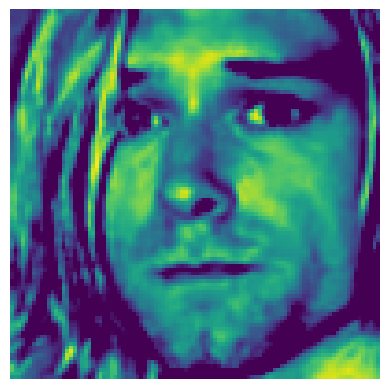

In [200]:
import matplotlib.pyplot as plt
import numpy as np  # If needed for conversion
import random

# Assuming image_tensor is your tensor data
# Convert tensor to NumPy array
image_array = example_data[random.randint(0,31)].numpy()  # PyTorch example; adjust accordingly for TensorFlow

# Reverse the normalization by scaling back to the original range [0, 255]
image_array = image_array * 255.0

# Clip values to ensure they are within the valid range [0, 255]
image_array = np.clip(image_array, 0, 255)

# Convert data type to unsigned 8-bit integer (uint8)
image_array = image_array.astype(np.uint8)

# If the tensor has color channels as the first dimension (e.g., [C, H, W])
# and you want to rearrange it to be [H, W, C] for display:
if len(image_array.shape) == 3:
    image_array = np.transpose(image_array, (1, 2, 0))  # Change the order of dimensions

# Display the image using Matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

In [201]:
tf.print(example_data)

[tensor([[[-0.3700, -0.3945, -0.3967,  ..., -0.5936, -0.6250, -0.6328],
         [-0.3288, -0.3491, -0.3477,  ..., -0.5867, -0.6172, -0.6172],
         [-0.2853, -0.2963, -0.2893,  ..., -0.5834, -0.6070, -0.6070],
         ...,
         [-0.3259, -0.4122, -0.4514,  ..., -0.2170, -0.3364, -0.3991],
         [-0.3181, -0.3887, -0.4279,  ..., -0.2876, -0.3913, -0.4227],
         [-0.3259, -0.4043, -0.4357,  ..., -0.3425, -0.4227, -0.4305]]]),
 tensor([[[-2.4749e-01, -2.5534e-01, -2.6497e-01,  ..., -9.3428e-01,
          -9.3662e-01, -9.3112e-01],
         [-2.8671e-01, -3.0329e-01, -3.1986e-01,  ..., -9.2643e-01,
          -9.3428e-01, -9.3112e-01],
         [-3.1573e-01, -3.4160e-01, -3.5818e-01,  ..., -9.1859e-01,
          -9.3428e-01, -9.3662e-01],
         ...,
         [-5.6307e-02, -2.7754e-02,  1.1458e-02,  ..., -2.0869e-01,
          -2.0869e-01, -2.0869e-01],
         [-7.9834e-02, -4.0623e-02,  1.1458e-02,  ..., -2.0869e-01,
          -2.0869e-01, -2.0869e-01],
         [-1.051

In [202]:
tf.print(example_targets)

tensor([1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])


In [210]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
#self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dense_shared = nn.Linear(50 * 50 * 64, 128)  # Calculate the input size based on your input_shape

        # Output layers
        self.classification_output = nn.Linear(128, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Identity()  # No activation for linear output

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.max_pool(x)

        # Flatten and pass through fully connected layers
        x = self.flatten(x)
        x = self.relu(self.dense_shared(x))

        # Classification branch
        classification_out = self.sigmoid(self.classification_output(x)).squeeze()
        
        return classification_out

In [211]:
model = CustomModel()
loss_func = nn.BCELoss()

In [212]:
# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed

train_losses = []
val_losses = []
# Training loop
epochs = 10  # Define the number of epochs for training
for epoch in range(epochs):
    print("epoch:", epoch)
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch_idx, (img_names, targets) in enumerate(train_loader):
        print(batch_idx)
        data = torch.stack([train_dataset.load_image(img_name) for img_name in img_names])
        # print(type(data))
        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        pred = model(data)  # Forward pass
         
        loss = loss_func(pred, targets)
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()

    # Calculate average loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0.0
        for batch_idx, (img_names, targets) in enumerate(val_loader):
            data = torch.stack([train_dataset.load_image(img_name) for img_name in img_names])
            pred = model(data)
            loss = loss_func(pred, targets)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{epochs}] - Validation Loss: {avg_val_loss:.4f}")

epoch: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
Epoch [1/10], Loss: 1.5055
Epoch [1/10] - Validation Loss: 0.5723
epoch: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
Epoch [2/10], Loss: 0.4855
Epoch [2/10] - Validation Loss: 0.4122
epoch: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79

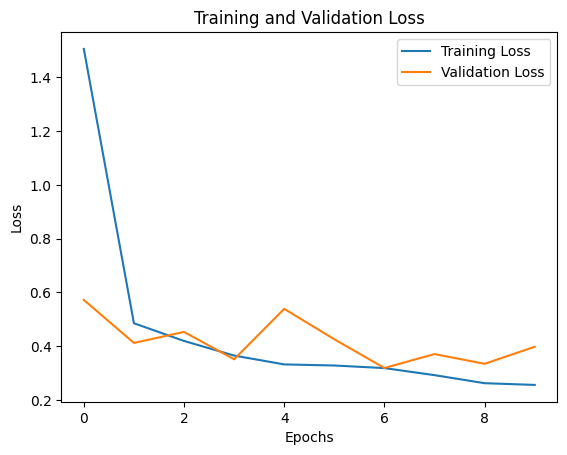

In [213]:
# Plotting losses over epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [216]:
# Set the model to evaluation mode
model.eval()

def calculate_accuracy(predictions, targets):
    return (predictions == targets).sum().item() / len(targets)

# Initialize variables to track correct predictions
total_correct = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for batch_idx, (img_names, targets) in enumerate(test_loader):
        data = torch.stack([test_dataset.load_image(img_name) for img_name in img_names])
        predictions = model(data)  # Get model predictions
        predictions = (predictions > 0.5).float()  # Apply a threshold (assuming it's a binary classification)

        print(f"Batch {batch_idx + 1}:")
        for i in range(len(targets)):
            print(f"Target: {targets[i]}, Predicted: {predictions[i]}")

            # Compare individual prediction and target
            if predictions[i] == targets[i]:
                total_correct += 1

        total_samples += len(targets)

# Calculate overall accuracy
accuracy = total_correct / total_samples

# Print accuracy
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# Compare accuracy against random chance (assuming a balanced dataset)
random_chance = 0.5  # For binary classification
if accuracy > random_chance:
    print("Model performs better than random chance.")
else:
    print("Model performs no better than random chance.")


Batch 1:
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 1.0, Predicted: 1.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 1.0
Target: 0.0, Predicted: 1.0
Target: 1.0, Predicted: 1.0
Target: 1.0, Predicted: 1.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 1.0, Predicted: 1.0
Target: 0.0, Predicted: 0.0
Target: 1.0, Predicted: 1.0
Target: 1.0, Predicted: 1.0
Target: 0.0, Predicted: 1.0
Target: 1.0, Predicted: 1.0
Target: 1.0, Predicted: 1.0
Target: 0.0, Predicted: 1.0
Target: 0.0, Predicted: 0.0
Target: 1.0, Predicted: 1.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 1.0
Target: 0.0, Predicted: 1.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 0.0, Predicted: 0.0
Target: 1.0, Predicted: 1.0
Batch 2:
Target: 1.0, Predicted: 1.0
Target: 1.0, Predicted: 1.0
Target: 0.0, Predicted: 0.0
Ta